In [1]:
# standard packages for data analysis and NLP

import numpy as np
import pandas as pd
from copy import deepcopy

#visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# NLP modules we will use for text normalization
import re #regex 
import nltk # the natural language toolkit
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

# feature construction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# import pyLDAvis.sklearn # a specialized package for topic model visualization

#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

import pickle
import time

# import data

In [2]:
df = pd.read_csv('processed_df\metacritic_comments_nlp.csv')
df

,Title,Userscore,Comment,lang
0,The Legend of Zelda: Ocarina of Time,10.0,"Everything in OoT is so near at perfection, it...",en
1,The Legend of Zelda: Ocarina of Time,10.0,I won't bore you with what everyone is already...,en
2,The Legend of Zelda: Ocarina of Time,10.0,Anyone who gives the masterpiece below a 7 or ...,en
3,The Legend of Zelda: Ocarina of Time,10.0,I'm one of those people who think that this is...,en
4,The Legend of Zelda: Ocarina of Time,10.0,This game is the highest rated game on Metacr...,en
...,...,...,...,...
249026,Etrian Odyssey Untold: The Millennium Girl,9.0,So you will know what type of gamer is writing...,en
249027,Etrian Odyssey Untold: The Millennium Girl,7.0,"Extremely similar to EO:4, which obviously isn...",en
249028,Etrian Odyssey Untold: The Millennium Girl,9.0,While I find the story mode to have annoying c...,en
249029,Etrian Odyssey Untold: The Millennium Girl,8.0,"Pretty good, but it certainly lacks the visual...",en


In [8]:
df.shape

(249031, 4)

In [ ]:
df.Userscore

# plots

- userscore distribution

In [4]:
df.Userscore.value_counts(normalize=True).sort_index()

1.0     0.028045
2.0     0.023399
3.0     0.027784
4.0     0.030896
5.0     0.039320
6.0     0.046508
7.0     0.065305
8.0     0.114773
9.0     0.205079
10.0    0.418892
Name: Userscore, dtype: float64

c:\Users\qwswe\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


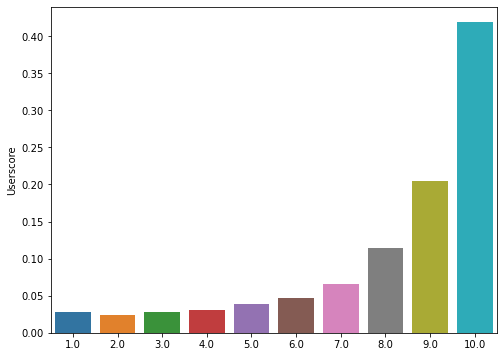

In [5]:
snsdf = df.Userscore.value_counts(normalize=True).sort_index()
snsdf = pd.DataFrame(snsdf)
snsdf

plt.figure(figsize=(8,6))
sns.barplot(snsdf.index, snsdf.Userscore);

# 41% user gave a 10.0

- length of comments

In [6]:
df['Comment_len'] = df['Comment'].map(lambda x: len(x))

c:\Users\qwswe\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


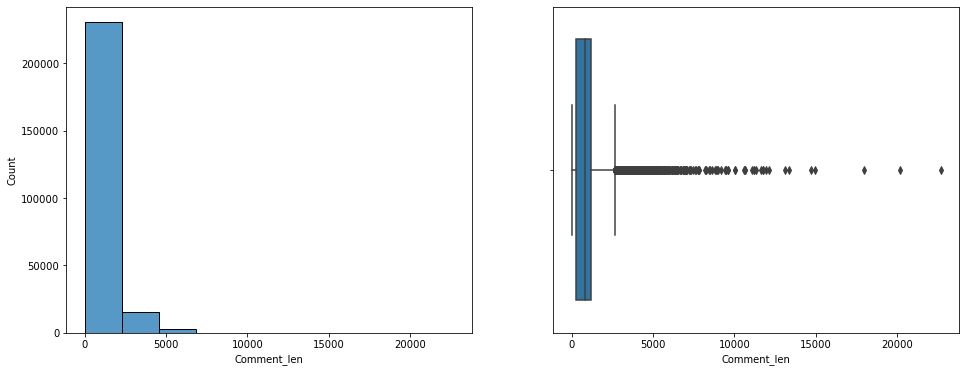

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))
sns.histplot(df['Comment_len'],bins=10, ax=ax1)
sns.boxplot(df['Comment_len'], ax=ax2);

<AxesSubplot:xlabel='Userscore', ylabel='Comment_len'>

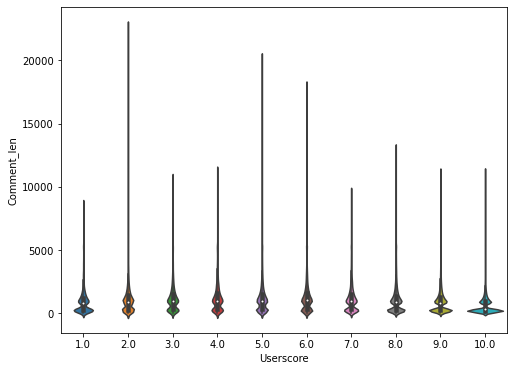

In [7]:
plt.figure(figsize=(8,6))
sns.violinplot(y=df['Comment_len'], x=df['Userscore'])

<AxesSubplot:xlabel='Userscore', ylabel='Comment_len'>

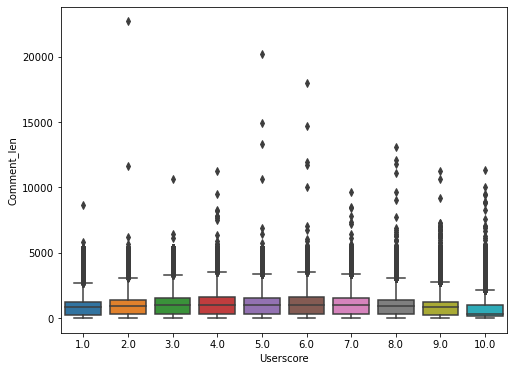

In [8]:
plt.figure(figsize=(8,6))
sns.boxplot(y=df['Comment_len'], x=df['Userscore'])

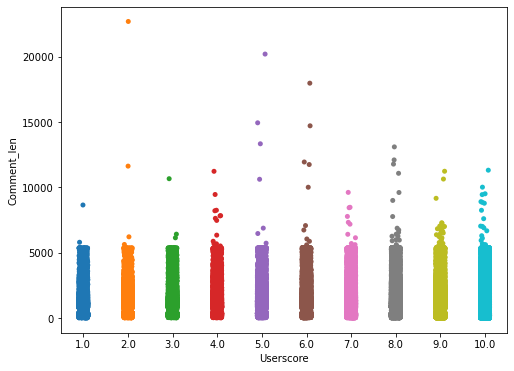

In [9]:
plt.figure(figsize=(8,6))
sns.stripplot(y=df['Comment_len'], x=df['Userscore']);

- popular game title

In [60]:
df['Title'].value_counts()

Call of Duty: Modern Warfare 3    3571
The Elder Scrolls V: Skyrim       3439
Diablo III                        3270
Mass Effect 3                     2944
Fallout 4                         2825
                                  ... 
Quell Memento                        1
Frozen Synapse Prime                 1
Super One More Jump                  1
escapeVektor: Chapter 1              1
Test Drive V-Rally                   1
Name: Title, Length: 2323, dtype: int64

<AxesSubplot:ylabel='Frequency'>

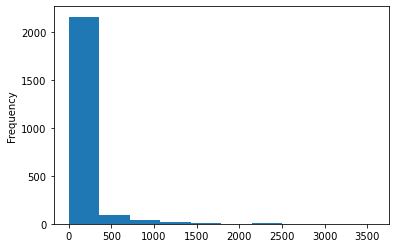

In [61]:
df.groupby('Title').size().plot(kind='hist', bins=10)

# text preprocessing

In [3]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_text(text, min_length):

    # drop non-english words
    words = set(nltk.corpus.words.words())
    # " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())

    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    text_lower = text.lower()
    
    # remove stop words and punctuations 
    text_norm = [x for x in word_tokenize(text_lower) if ((x.isalpha()) & (x not in stop_words))]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text_norm))) 

    # cutoff for tokenized length
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
         text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
         return text_norm

In [10]:
# subset the dataset p * origin
# then do text process
# lastly, get rid of null, na and duplicates, because of the limit of length

def subset_and_process(p, df, colname):
    
    start = time.time()

    sample_size = int(df.shape[0]*p)
    print(f'subset size: {sample_size}')
    print(f'full dataset size: {df.shape[0]}')
    print(f'{p*100}%')

    df_sub = df.sample(sample_size,random_state=2333) 
    df_sub[colname].value_counts(normalize=True)

    start = time.time()
    df_sub[colname] = df_sub[colname].apply(process_text, min_length = 10)
    end = time.time()
    print(f'{end-start} seconds slipped.')

    df_new = df_sub[df_sub[colname] != '']
    df_new.drop_duplicates(inplace=True)

    print(f'output dataset size: {df_new.shape[0]}')
    
    end = time.time()
    print(f'{end-start} secs slipped..')

    return df_new

In [5]:
df_need_proc = pd.read_csv('processed_df\df_need_proc.csv')
df_need_proc

,Title,Platform,Userscore,Comment,Username,lang
0,The Legend of Zelda: Ocarina of Time,Nintendo64,NaN,"I was very disappointed by this game, as it di...",Thajocoth,en
1,The Legend of Zelda: Ocarina of Time,Nintendo64,NaN,The original Legend of Zelda: Ocarina of Time ...,The_Legend,en
2,The Legend of Zelda: Ocarina of Time,Nintendo64,NaN,I played it for the first time last year and w...,thedaarkbatty,en
3,The Legend of Zelda: Ocarina of Time,Nintendo64,NaN,The Legend of Zelda: Ocarina of Time for Ninte...,sweg,en
4,The Legend of Zelda: Ocarina of Time,Nintendo64,NaN,"Boring game, graphics suck, gameplay is borin...",J-malJ,en
...,...,...,...,...,...,...
19137,Assassin's Creed: Revelations,PC,NaN,"I got this solely for the multiplayer, which i...",Not_Casual,en
19138,Assassin's Creed: Revelations,PC,NaN,"Boring, repetitive, predictable, booooring, I ...",monkeylion,en
19139,Assassin's Creed: Revelations,PC,NaN,"At 87%, 39 hours elapsed and finished the game...",Mykwon,en
19140,Battle Brothers,PC,NaN,So much promise so little gameplay. Played al...,riley794,en


In [11]:
df_ready_for_impute = subset_and_process(0.01,df_need_proc,'Comment')

subset size: 191
full dataset size: 19142
1.0%
19.897075414657593 seconds slipped.
output dataset size: 181
19.897075414657593 secs slipped..


<ipython-input-10-94140c5259c4>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop_duplicates(inplace=True)


In [12]:
df_ready_for_impute

,Title,Platform,Userscore,Comment,Username,lang
694,God of War,PlayStation4,NaN,pull teeth god war soft reboot suffers issue c...,halexman99,en
4192,Dota 2,PC,NaN,game good take valve get bad game game become ...,samsu8,en
11669,Call of Duty: Modern Warfare 2,PC,NaN,many glitch exploit make game unfairly play al...,Logan,en
4130,Dota 2,PC,NaN,diretideno new herono updatesno normal matchma...,GIVEDIRETIDESUC,en
11580,Call of Duty: Modern Warfare 2,PC,NaN,wth remove dedicated server avaliable sdk game...,PsyA,en
...,...,...,...,...,...,...
1397,Minecraft,PC,NaN,game absolute rubbish combat mindlessly simple...,spinspock,en
12617,Battlefield 4,PlayStation4,NaN,game potential best shooter ever make break pa...,jhould,en
12240,Assassin's Creed II,PC,NaN,game treat criminal simply worth pay worth pla...,Nick,en
14769,FIFA 18,PlayStation4,NaN,surely much complaint script ea take note take...,Hoopla,en


In [13]:
df_ready_for_impute.to_csv(r'processed_df\df_ready_for_impute.csv', index = False)

In [23]:
df_sub_1 = subset_and_process(0.01,df,'Comment')

subset size: 2490
full dataset size: 249031
1.0%
230.58182573318481 seconds slipped.


In [24]:
df_sub_1.to_pickle('processed_df/preprocessed_nlp_1p.pkl')

In [19]:
df_sub_30 = subset_and_process(0.3,df,'Comment')

subset size: 74709
full dataset size: 249031
30.0%
5379.484248876572 seconds slipped.


In [21]:
df_sub_30.to_pickle('processed_df/preprocessed_nlp_30p.pkl')

In [ ]:
df_full_proc = subset_and_process(1,df,'Comment')
df_full_proc.to_pickle('processed_df/preprocessed_nlp_100p.pkl')

**pickle**

In [5]:
df_sub_30 = pd.read_csv('processed_df\preprocessed_nlp_30p.csv')
df_sub_30.shape

(74709, 4)

In [6]:
# df_sub.to_pickle('processed_df/preprocessed_nlp_5p.pkl')
# proprocessed texts, 155554, non-english, no userscore 0.0

df_sub_30 = pickle.load(open('processed_df/preprocessed_nlp_30p.pkl','rb'))

# TFIDF

In [12]:
# after proprocess, there will be empty comment
# due to min_length

df_new = df_sub_30[df_sub_30['Comment'] != '']


In [13]:
df_new.shape

(70593, 4)

In [14]:
corpus = df_new['Comment']
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus)
X_train

<70593x77402 sparse matrix of type '<class 'numpy.float64'>'
	with 3474522 stored elements in Compressed Sparse Row format>

In [15]:
X_train.shape

(70593, 77402)

In [29]:
feature_names = vectorizer.get_feature_names() #get tfidf vector for first document 
first_document_vector = X_train[0]  #print the scores 
df_temp = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df_temp.sort_values(by=["tfidf"],ascending=False).head(15)

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
squanders,0.339371
droids,0.323706
platoon,0.274348
imperial,0.261507
reinforcement,0.257716
rebel,0.247499
side,0.236616
troop,0.220651
victory,0.210423
pathetic,0.199607


# Topic Modeling

In [30]:
topic_model = NMF(n_components = 7)
topic_model.fit(X_train)

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=7)

In [31]:
# to get H
H = topic_model.transform(X_train) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

print("Shape of W is " + str(W.shape))
print("Shape of H is " + str(H.shape))
print("Shape of X_train is " + str(X_train.shape))

Shape of W is (7, 77402)
Shape of H is (70593, 7)
Shape of X_train is (70593, 77402)


In [32]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0


c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['enjoy', 'day', 'really', 'come', 'still', 'know', 'even', 'want', 'go', 'review', 'never', 'think', 'first', 'say', 'hour', 'year', 'give', 'buy', 'fun', 'people', 'time', 'love', 'get', 'play', 'game']


THE TOP 10 WORDS FOR TOPIC #1
['easily', 'everything', 'probably', 'beautiful', 'video', 'amazing', 'world', 'simply', 'uncharted', 'awesome', 'masterpiece', 'series', 'far', 'year', 'perfect', 'gameplay', 'rpg', 'story', 'amaze', 'graphic', 'make', 'play', 'game', 'ever', 'best']


THE TOP 10 WORDS FOR TOPIC #2
['visuals', 'recommend', 'voice', 'storyline', 'atmosphere', 'well', 'perfect', 'puzzle', 'excellent', 'soundtrack', 'beautiful', 'sound', 'love', 'fantastic', 'music', 'fun', 'amazing', 'character', 'awesome', 'amaze', 'game', 'gameplay', 'graphic', 'story', 'great']


THE TOP 10 WORDS FOR TOPIC #3
['well', 'team', 'play', 'weapon', 'zombie', 'modern', 'black', 'warfare', 'shooter', 'ops', 'fps', 'battlefield', 'fun', 'online', 'call', 'new', 'duty', 'map', 'cod', 'mode', '

In [35]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 7, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


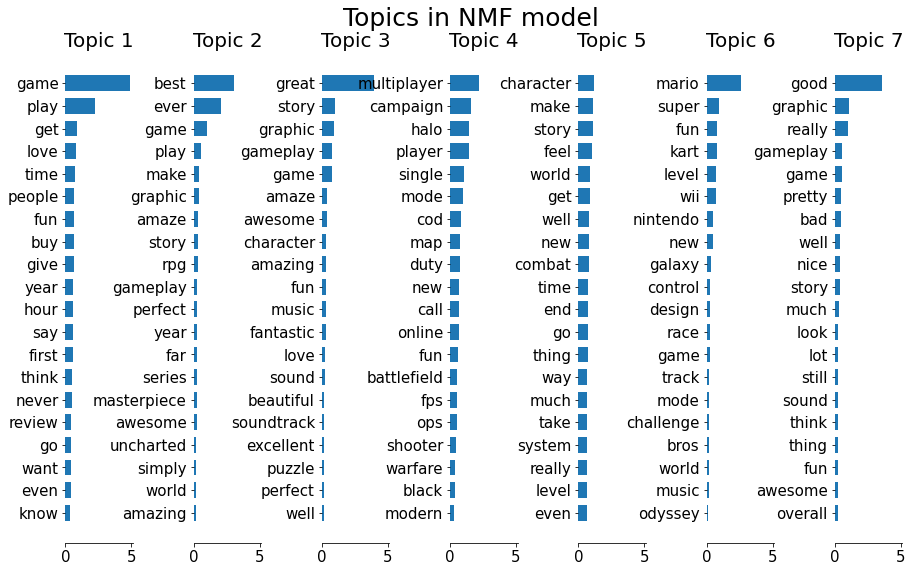

In [36]:
topic_word_plot()

In [39]:
topic_name_dict = {0: 'general good game', 1: 'rpg', 2: 'amazing story and audio',
                   3: 'multiplayer shooter', 4: 'combat world', 5:'nintendo', 6:'overall good'}

# TSNE

In [38]:
tsne = TSNE(random_state=42, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [40]:
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

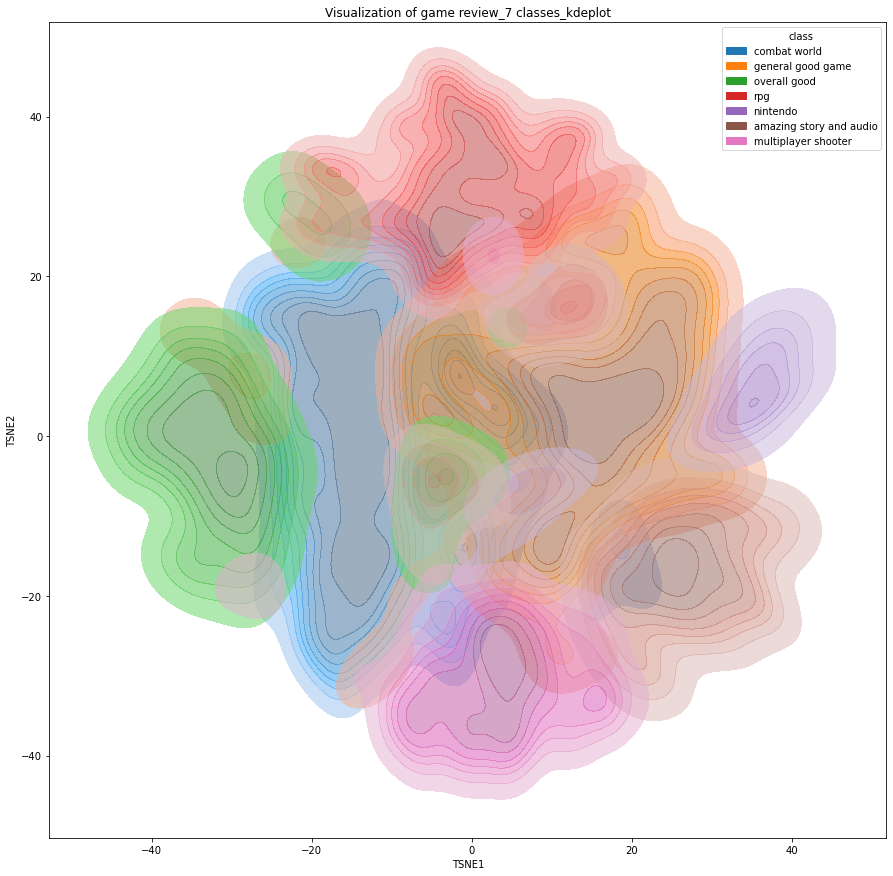

In [41]:
plt.figure(figsize=(15,15))
sns.kdeplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10', fill=True, alpha=.5)
plt.title('Visualization of game review_7 classes_kdeplot')
plt.show()

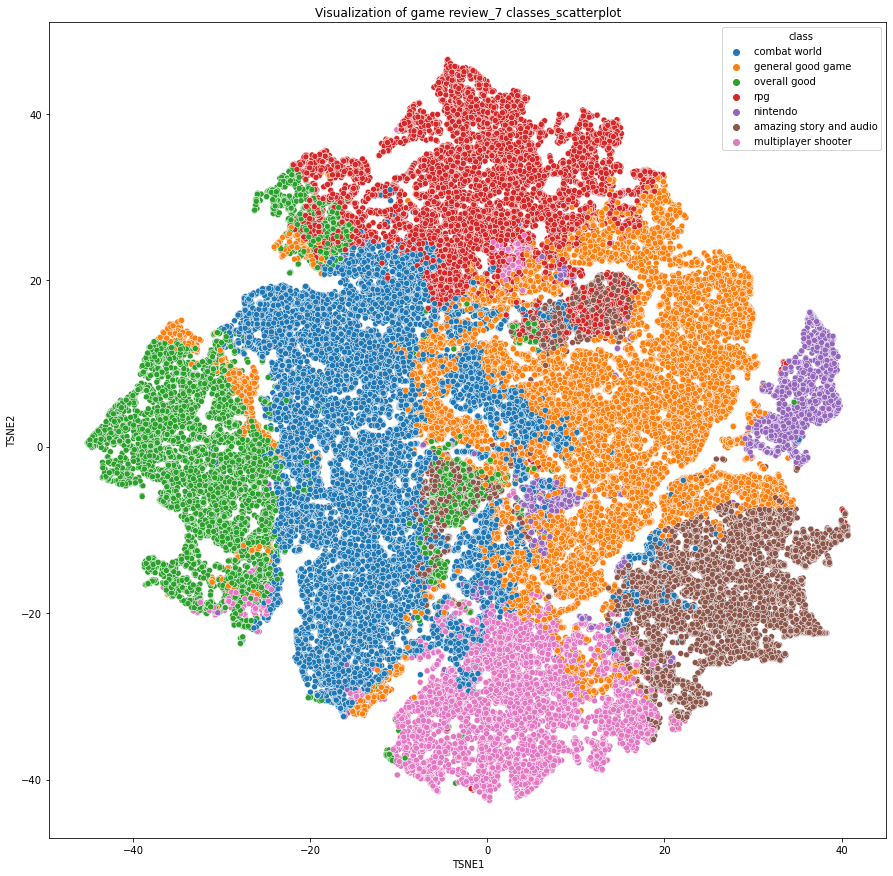

In [43]:
plt.figure(figsize=(15,15))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans)
plt.title('Visualization of game review_7 classes_scatterplot')
plt.show()

slightly the topics differ from each other, so the reviews should help predict the score